In [1]:
import torch
import numpy as np
import pandas as pd
import wfdb


In [32]:
# work done in hylian machine

waveform_summary = pd.read_csv("/tmp/mc-med-1.0.0/data/waveform_summary.csv")
waveform_summary = waveform_summary[waveform_summary['Type'] == 'II']
waveform_summary.head()

,CSN,Type,Segments,Duration
0,99633476,II,1,2204.742
4,99960476,II,4,12818.304
7,99470476,II,2,13918.498
11,99438476,II,2,11579.046
15,99439476,II,3,2853.788


In [3]:
waveform_summary['CSN']

0         99633476
4         99960476
7         99470476
11        99438476
15        99439476
            ...   
188298    99413106
188306    99876106
188307    99539106
188310    99647106
188314    99289106
Name: CSN, Length: 55160, dtype: int64

In [4]:
Full_CSN = 99016000

In [5]:
waveform_summary[waveform_summary['CSN'] == Full_CSN]

,CSN,Type,Segments,Duration
58946,99016000,II,2,1166.926


## Waveform Data -- we use ECG
The data are organized into compressed archives (waveforms_0xx.zip, waveforms_1xx.zip, etc.) based on the last three digits of each Visit ID (CSN). Each ZIP archive extracts to a nested folder structure:

```
    {CSN_suffix}/              # Folder named by last three digits of the CSN
        {Full_CSN}/            # Folder named by the full CSN (visit identifier)
            II/                # ECG waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
            Pleth/             # PPG waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
                ...
            Resp/              # Respiration waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
```

### Some pre-processing

In [29]:
CSN_suffix = '000'
waveform_type = 'II'
records_path = f"/tmp/mc-med-1.0.0/data/waveforms/{CSN_suffix}/RECORDS"

with open(records_path, "r") as f:
    lines = f.read().split('\n')

segment_paths = [line for line in lines if waveform_type in line]
# segment_paths

In [7]:
patient_ids = torch.tensor([int(segment_path[:8]) for segment_path in segment_paths]).unique()
print(patient_ids.shape)
patient_ids

torch.Size([53])


tensor([99016000, 99056000, 99062000, 99082000, 99085000, 99090000, 99096000,
        99110000, 99140000, 99153000, 99164000, 99180000, 99184000, 99260000,
        99261000, 99327000, 99332000, 99339000, 99373000, 99386000, 99417000,
        99423000, 99447000, 99474000, 99480000, 99485000, 99497000, 99499000,
        99509000, 99528000, 99553000, 99569000, 99571000, 99632000, 99650000,
        99660000, 99708000, 99713000, 99743000, 99761000, 99772000, 99782000,
        99831000, 99848000, 99855000, 99865000, 99867000, 99879000, 99890000,
        99896000, 99923000, 99982000, 99998000])

In [30]:
patients_segments_dict = {}

for patient_id in patient_ids:
    patients_segments_dict[patient_id.item()] = [segment_path for segment_path in segment_paths if int(segment_path[:8]) == patient_id.item()]

# patients_segments_dict

In [31]:
patients_records_dict = {}

for patient_id in patients_segments_dict:
    record_list = []
    for segment_path in patients_segments_dict[patient_id]:
        data_path = f"/tmp/mc-med-1.0.0/data/waveforms/{CSN_suffix}/{segment_path}"
        # Read the record
        record = wfdb.rdrecord(data_path)
        record_list.append(record)
    patients_records_dict[patient_id] = record_list

# patients_records_dict

### ok we are ready to go!

In [20]:
Full_CSN = 99016000 # Full_CSN is another name for patient_id

patients_records_dict[Full_CSN]

In [21]:
record1 = patients_records_dict[Full_CSN][0]
print(record1.__dict__)

{'record_name': '99016000_1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 11089, 'base_time': datetime.time(6, 48, 20, 721000), 'base_date': datetime.date(2294, 9, 18), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.85953552],
       [-0.85508197],
       [-0.85953552],
       ...,
       [ 1.54092896],
       [ 1.60995902],
       [ 1.67008197]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99016000_1.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [449.079754601227], 'baseline': [149], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-237], 'checksum': [12774], 'block_size': [0]}


In [25]:
from datetime import datetime, timedelta

start_dt = datetime.combine(datetime.today(), record1.base_time)
duration_sec = record.sig_len / record.fs
end_dt = start_dt + timedelta(seconds=duration_sec)

print("Start time:", record1.base_time)
print("End time:", end_dt.time())


Start time: 06:48:20.721000
End time: 07:49:33.625000


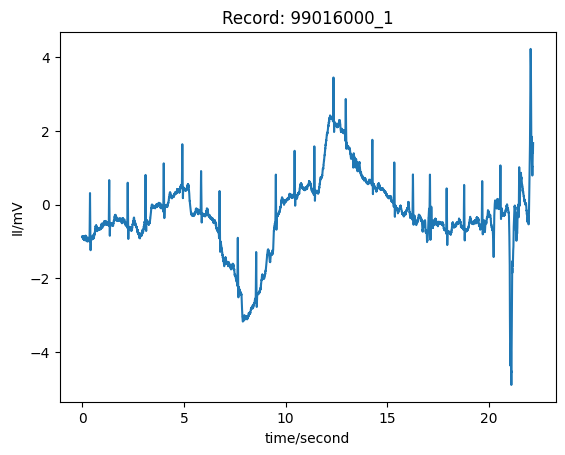

In [23]:
wfdb.plot_wfdb(record=record1)

In [22]:
record2 = patients_records_dict[Full_CSN][1]
print(record2.__dict__)

{'record_name': '99016000_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 572374, 'base_time': datetime.time(8, 19, 58, 121000), 'base_date': datetime.date(2294, 9, 18), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.01028235],
       [-0.02523849],
       [-0.01028235],
       ...,
       [-0.93475877],
       [-0.87026042],
       [-0.85997807]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99016000_2.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [1069.7947214076246], 'baseline': [-223], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-234], 'checksum': [53235], 'block_size': [0]}


In [26]:
from datetime import datetime, timedelta

start_dt = datetime.combine(datetime.today(), record2.base_time)
duration_sec = record.sig_len / record.fs
end_dt = start_dt + timedelta(seconds=duration_sec)

print("Start time:", record2.base_time)
print("End time:", end_dt.time())


Start time: 08:19:58.121000
End time: 09:21:11.025000


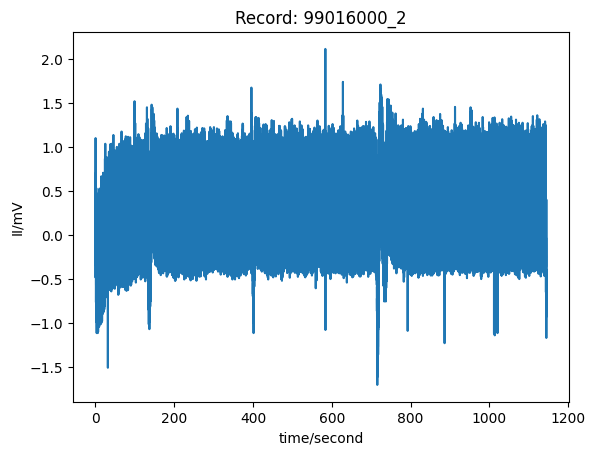

In [24]:
wfdb.plot_wfdb(record=record2)

In [36]:
# Read the record
record = wfdb.rdrecord(ecg_waveform_data_path)

# Access signal data
signal = record.p_signal  # shape: (samples, channels)
print("Signal shape:", signal.shape)

# Print sampling frequency and signal names
print("Sampling Frequency:", record.fs)
# print("Signal Names:", record.sig_name)

# View metadata
print(record.__dict__)

Signal shape: (11089, 1)
Sampling Frequency: 500
{'record_name': '99016000_1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 11089, 'base_time': datetime.time(6, 48, 20, 721000), 'base_date': datetime.date(2294, 9, 18), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.85953552],
       [-0.85508197],
       [-0.85953552],
       ...,
       [ 1.54092896],
       [ 1.60995902],
       [ 1.67008197]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99016000_1.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [449.079754601227], 'baseline': [149], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-237], 'checksum': [12774], 'block_size': [0]}


In [37]:
record.__dict__.keys()

dict_keys(['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'])

### import alarm data

In [27]:
import pandas as pd

alarms_df = pd.read_parquet('../data/sick_time.parquet', engine='pyarrow') 

In [28]:
alarms_df

,CSN,Alarm
0,98974916,2288-12-08 10:17:39
1,98975250,2279-10-24 08:40:37
2,98982225,2238-07-19 10:31:15
3,98990360,2242-01-14 19:43:37
4,98995384,2276-05-18 10:59:45
...,...,...
438,99994144,2228-04-08 15:13:19
439,99995451,2273-04-24 12:04:55
440,99996003,2225-03-31 12:08:57
442,99997362,2205-12-12 16:44:12


In [13]:
Full_CSN

99016000

In [12]:
df[df['CSN'] == Full_CSN]

,CSN,Alarm
